# Compare RMG to the Grabow model

In [62]:
import os
from random import randint
import pandas as pd
import numpy as np
import csv
import cantera as ct
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

import seaborn
plt.style.use('seaborn-white')
from pathlib import Path
import time

import matplotlib.cm as cm
from IPython.display import Image
from rmgpy import chemkin

## Git-python: checkout master branch

In [2]:
# RMG model path that is being analyzed. cantera analysis have a folder name 
# based off of the commit message, hash, and date
# rmg_model_path = "/work/westgroup/ChrisB/_01_MeOH_repos/RMG_run_comparisons/bep_parameter_study/rmg_runs/meoh_main/"
rmg_model_path = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/"

## Load a list of reactions for each species generation rate

In [3]:
cantera_path = rmg_model_path + "base/cantera/"
cti_file = cantera_path + "chem_annotated.cti"


gas = ct.Solution(cti_file)
surface = ct.Interface(cti_file, "surface1", [gas])

model_dict_file = rmg_model_path + "base/chemkin/species_dictionary.txt"
grabow_dict_file = "./species_data/species_dictionary.txt"

In [4]:
model_dict = chemkin.load_species_dictionary(model_dict_file)
grabow_dict = chemkin.load_species_dictionary(grabow_dict_file)

In [5]:
# make a dictionary to "translate" the names from the grabow model to ours
# irrespective of the naming convention.
spc_trans = {}
for name, entry in model_dict.items(): 
    for g_name, g_entry in grabow_dict.items():
        if entry.is_isomorphic(g_entry):
            # remove (#) so it is neater
            g_name_new = g_name.split("(", 1)[0]
            spc_trans.update({g_name_new :name})
spc_trans                   

{'N2': 'N2',
 'Ne': 'Ne',
 'X': 'X(1)',
 'H2': 'H2(2)',
 'CO': 'CO(3)',
 'CO2': 'CO2(4)',
 'H2O': 'H2O(5)',
 'CH2O': 'CH2O(6)',
 'HCOOH': 'HCOOH(7)',
 'CH3OH': 'CH3OH(8)',
 'HCOOCH3': 'HCOOCH3(9)',
 'H*': 'H*(10)',
 'O*': 'O*(11)',
 'OH*': 'OH*(12)',
 'H2O*': 'H2O*(13)',
 'CO*': 'CO*(14)',
 'CO2*': 'CO2*(15)',
 'HCO*': 'HCO*(16)',
 'HCOO*': 'HCOO*(17)',
 'COOH*': 'COOH*(18)',
 'HCOOH*': 'HCOOH*(19)',
 'CH2O*': 'CH2O*(20)',
 'CH3O*': 'CH3O*(21)',
 'CH3O2*': 'CH3O2*(22)',
 'CH3OH*': 'CH3OH*(23)',
 'CH4': 'CH4(24)',
 'H2*': 'H2X(53)'}

In [73]:
# read in dataframe for run
data_all = pd.read_csv(cantera_path+ "ct_analysis.csv")
data_graaf = data_all[data_all['experiment'] == "graaf_1988"]
data_grab = data_all[(data_all['experiment'] == "grabow2011") & (data_all['T (K)'] < 518)]

## get reactions for each one listed in TOF chart in grabow paper

     Grabow study name      |  Cantera label or formula
     --------------------------------------------------
     "Methanol Production"  |  methanol net production rate  
     "Water-Gas Shift"      |  OH* + CO* -> COOH* + *. although RLS is supp H2O* + X --> H* + *OH
     "CO Hydrogenation"     |  Any reaction where CO receives an H and goes to HCO*. 
     "CO2 Hydrogenation"    |  Any reaction where CO2 receives an H and goes to HCO2*
     "H2O Production"       |  rate of H2O*
     
     
     H2O shift

In [7]:
co_co2_label = "CO2/(CO2+CO)"

In [8]:
for index,rxn in enumerate(surface.reactions()):
    if spc_trans["H2O"] in rxn.equation:
        surface.set_multiplier(0,index)


functions for grabbing ROP data

### methanol

In [9]:
rop_str = " ROP [kmol/m^2 s]"        
ch3oh_dict = {}  
        
for rxn in surface.reactions():
    if spc_trans["CH3OH"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CH3OH"] in rxn.product_string:
            print(rxn_string, "forward")
            ch3oh_dict.update({rxn_string:1})
        elif spc_trans["CH3OH"] in rxn.reactant_string: 
            print(rxn_string, "reverse")
            ch3oh_dict.update({rxn_string:-1})

CH3OH(8) + X(1) <=> CH3OH*(23) ROP [kmol/m^2 s] reverse
CH3OH(8) + 2 X(1) <=> CH3O*(21) + H*(10) ROP [kmol/m^2 s] reverse


In [10]:
data_grab["Methanol TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in ch3oh_dict.items():
    if direct == 1:
        data_grab["Methanol TOF ($s^{-1}$)"] += data_grab[rxn]/surface.site_density
    elif direct == -1:
        data_grab["Methanol TOF ($s^{-1}$)"] -= data_grab[rxn]/surface.site_density

/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Water-Gas Shift
overall: $CO + H_2O <--> CO_2 + H_2$ 



In [11]:
wgs_hyd_dict = {}
# for rxn in surface.reactions():
# #     if spc_trans["CO*"] in rxn.reactant_string and spc_trans["OH*"] in rxn.reactant_string:
#     if spc_trans["CO2*"] in rxn.reactant_string and spc_trans["COOH*"] in rxn.product_string:
#         rxn_string = rxn.equation + rop_str
#         print(rxn.equation, "forward")
#         wgs_hyd_dict.update({rxn_string:-1})
#     elif spc_trans["COOH*"] in rxn.reactant_string and spc_trans["CO2*"] in rxn.product_string:
#         rxn_string = rxn.equation + rop_str
#         print(rxn.equation, "forward")
#         wgs_hyd_dict.update({rxn_string:1})

In [12]:
# # hardcode HOX(19) + OCX(17) <=> HOCXO(23) + X(1) for now just to analyze
wgs_hyd_dict.update(
    {f'{spc_trans["CO*"]} + {spc_trans["OH*"]} <=> {spc_trans["COOH*"]} + {spc_trans["X"]}{rop_str}':1
#     {f'{spc_trans["H2O*"]} + {spc_trans["X"]} <=> {spc_trans["H*"]} + {spc_trans["OH*"]}{rop_str}':1 
#     {f'{spc_trans["CO*"]} + {spc_trans["OH*"]} <=> {spc_trans["COOH*"]} + {spc_trans["X"]}{rop_str}':1
    }
)

In [13]:
data_grab["WGS Reaction TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in wgs_hyd_dict.items():
    if direct == 1:
        data_grab["WGS Reaction TOF ($s^{-1}$)"] += data_grab[rxn]/surface.site_density
    elif direct == -1:
        data_grab["WGS Reaction TOF ($s^{-1}$)"] -= data_grab[rxn]/surface.site_density

/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


 ### CO hydrogenation

In [14]:
co_hyd_dict = {}
rop_str = " ROP [kmol/m^2 s]"
for rxn in surface.reactions():
    if spc_trans["CO*"] in rxn.equation and spc_trans["HCO*"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CO*"] in rxn.reactant_string and not spc_trans["HCO*"] in rxn.reactant_string:
            print(rxn.equation, "forward")
            co_hyd_dict.update({rxn_string:1})
        elif spc_trans["CO*"] in rxn.product_string and not spc_trans["HCO*"] in rxn.product_string: 
            print(rxn.equation, "reverse")
            co_hyd_dict.update({rxn_string:-1})

CO*(14) + H*(10) <=> HCO*(16) + X(1) forward
HCO*(16) + O*(11) <=> CO*(14) + OH*(12) reverse
HCO*(16) + OH*(12) <=> CO*(14) + H2O*(13) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + COOH*(18) reverse
HCO*(16) + HCOO*(17) <=> CO*(14) + HCOOH*(19) reverse
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CH2O*(20) + CO*(14) <=> 2 HCO*(16) forward
CH2O*(20) + HCO*(16) <=> CH3O*(21) + CO*(14) reverse
HCO*(16) + HCOOH*(19) <=> CH3O2*(22) + CO*(14) reverse
CH3O*(21) + HCO*(16) <=> CH3OH*(23) + CO*(14) reverse
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + HCOOH*(19) <=> COOH*(18) + HCO*(16) forward
CO*(14) + H2X(53) <=> H*(10) + HCO*(16) forward


In [15]:
data_grab["CO Hydrogenation TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in co_hyd_dict.items():
    if direct == 1:
        data_grab["CO Hydrogenation TOF ($s^{-1}$)"] += data_grab[rxn]/surface.site_density
    elif direct == -1:
        data_grab["CO Hydrogenation TOF ($s^{-1}$)"] -= data_grab[rxn]/surface.site_density

/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set

### CO2 hydrogenation

In [16]:
co2_hyd_dict = {}
rop_str = " ROP [kmol/m^2 s]"
for rxn in surface.reactions():
    if spc_trans["CO2*"] in rxn.equation and spc_trans["HCOO*"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["CO2*"] in rxn.reactant_string and not spc_trans["HCOO*"] in rxn.reactant_string:
            print(rxn.equation, "forward")
            co2_hyd_dict.update({rxn_string:1})
        elif spc_trans["CO2*"] in rxn.product_string and not spc_trans["HCOO*"] in rxn.product_string: 
            print(rxn.equation, "reverse")
            co2_hyd_dict.update({rxn_string:-1})

CO2*(15) + H*(10) <=> HCOO*(17) + X(1) forward
CO2*(15) + OH*(12) <=> HCOO*(17) + O*(11) forward
HCOO*(17) + OH*(12) <=> CO2*(15) + H2O*(13) reverse
CO2*(15) + HCO*(16) <=> CO*(14) + HCOO*(17) forward
2 HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
HCO*(16) + HCOO*(17) <=> CH2O*(20) + CO2*(15) reverse
CH3O*(21) + HCOO*(17) <=> CH3OH*(23) + CO2*(15) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
COOH*(18) + HCOO*(17) <=> CO2*(15) + HCOOH*(19) reverse
CO2*(15) + H2X(53) <=> H*(10) + HCOO*(17) forward


In [17]:
data_grab["CO2 Hydrogenation TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in co2_hyd_dict.items():
    if direct == 1:
        data_grab["CO2 Hydrogenation TOF ($s^{-1}$)"] += data_grab[rxn]/surface.site_density
    elif direct == -1:
        data_grab["CO2 Hydrogenation TOF ($s^{-1}$)"] -= data_grab[rxn]/surface.site_density

/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set

### H2O production

In [18]:
h2o_dict = {}        
for rxn in surface.reactions():
    if spc_trans["H2O"] in rxn.equation: 
        rxn_string = rxn.equation + rop_str
        if spc_trans["H2O"] in rxn.reactant_string:
            print(rxn.equation, "reverse")
            h2o_dict.update({rxn_string:-1})
        elif spc_trans["H2O"] in rxn.product_string: 
            print(rxn.equation, "forward")
            h2o_dict.update({rxn_string:1}) 

H2O(5) + X(1) <=> H2O*(13) reverse
H2O(5) + 2 X(1) <=> H*(10) + OH*(12) reverse


In [19]:
data_grab["H2O TOF ($s^{-1}$)"] = 0 #(initialize)
for rxn, direct in h2o_dict.items():
    if direct == 1:
        data_grab["H2O TOF ($s^{-1}$)"] += data_grab[rxn]/surface.site_density
    elif direct == -1:
        data_grab["H2O TOF ($s^{-1}$)"] -= data_grab[rxn]/surface.site_density

/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/blais.ch/.conda/envs/rmg_julia_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### surface site density ($\frac{kmol}{m^2}$)

In [20]:
surface.site_density
site_dens_mol = surface.site_density*1e-3
site_dens_mol

2.943e-11

### TOF Calculation from ROP: 

$ROP\left[\frac{kmoles}{m^{2}*s}\right] * \frac{1}{\Gamma} \left[\frac{m^2}{kmol}\right] = TOF \left[\frac{1}{sec}\right]$   

## Turn over frequency comparison

Compare turn over frequencies for reaction(s) in the methanol model



In [21]:
Image('../images/Grabow_plots/Grabow_TOF.png',width = 700, height = 300)

FileNotFoundError: No such file or directory: '../images/Grabow_plots/Grabow_TOF.png'

FileNotFoundError: No such file or directory: '../images/Grabow_plots/Grabow_TOF.png'

<IPython.core.display.Image object>

### Load Grabow Data

In [22]:
Grabow_rates = pd.read_csv("./paper_data/Grabow_rates.csv")
Grabow_cov = pd.read_csv("./paper_data/Grabow_coverages.csv")

### Make TOF plot functions

In [53]:
def plot_rates_grabow(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    grabow_labels = [
        "Methanol Production",
        "Water-Gas Shift",
        "CO Hydrogenation",
        "CO2 Hydrogenation",
        "H2O Production",]
    
    h2_label = "y(H2)"
    co_co2_label = "CO2/(CO+CO2)"
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    
    axes = [(0,0), (0,1), (1,0), (1,1)]
    
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(grabow_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df["y(H2)"], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax=ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("Turn over frequency ($s^{-1}$)")
    
    return fig

def plot_rates_rmg(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    # this part is tricky. 
    
    #         "Methanol Production"  :  CH3O* + H* -> CH3OH* + *
    #         "Water-Gas Shift"      :  OH* + CO* -> COOH* + *
    #         "CO Hydrogenation"     :  CO* + H* -> HCO* + *
    #         "CO2 Hydrogenation"    :  CO2* + H* -> HCO2* + *
    #         "H2O Production"       :  #1 - #2
    #                                   #1:  H2O*+*->OH*+H*
    #                                   #2:  COOH* + OH* -> CO2* + H2O*
    rmg_labels = [
        "Methanol TOF ($s^{-1}$)",
        "WGS Reaction TOF ($s^{-1}$)",
        "CO Hydrogenation TOF ($s^{-1}$)",
        "CO2 Hydrogenation TOF ($s^{-1}$)",
        "H2O TOF ($s^{-1}$)",
    ]
        
    h2_label = "x_H2 initial"
    co_co2_label = "CO2/(CO2+CO)"
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    axes = [(0,0), (0,1), (1,0), (1,1)]

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(rmg_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df[h2_label], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax =ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("Turn over frequency ($s^{-1}$)")
    
    return fig



### Plot TOFs

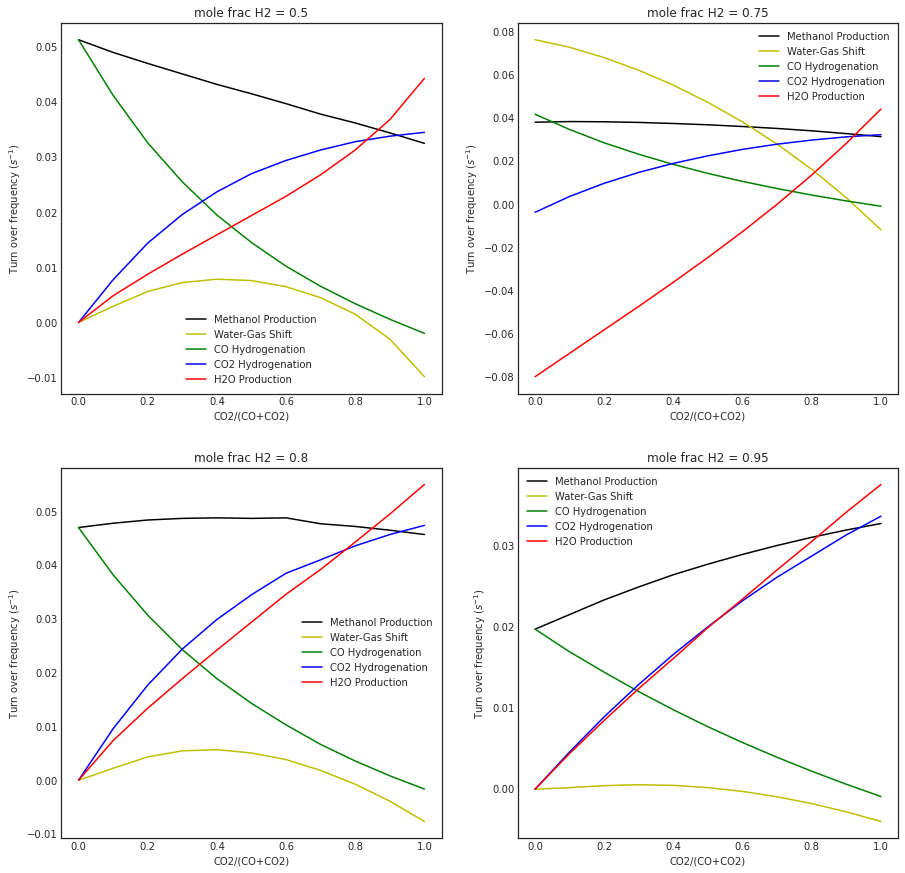

In [54]:
fig_grab_rates = plot_rates_grabow(Grabow_rates)

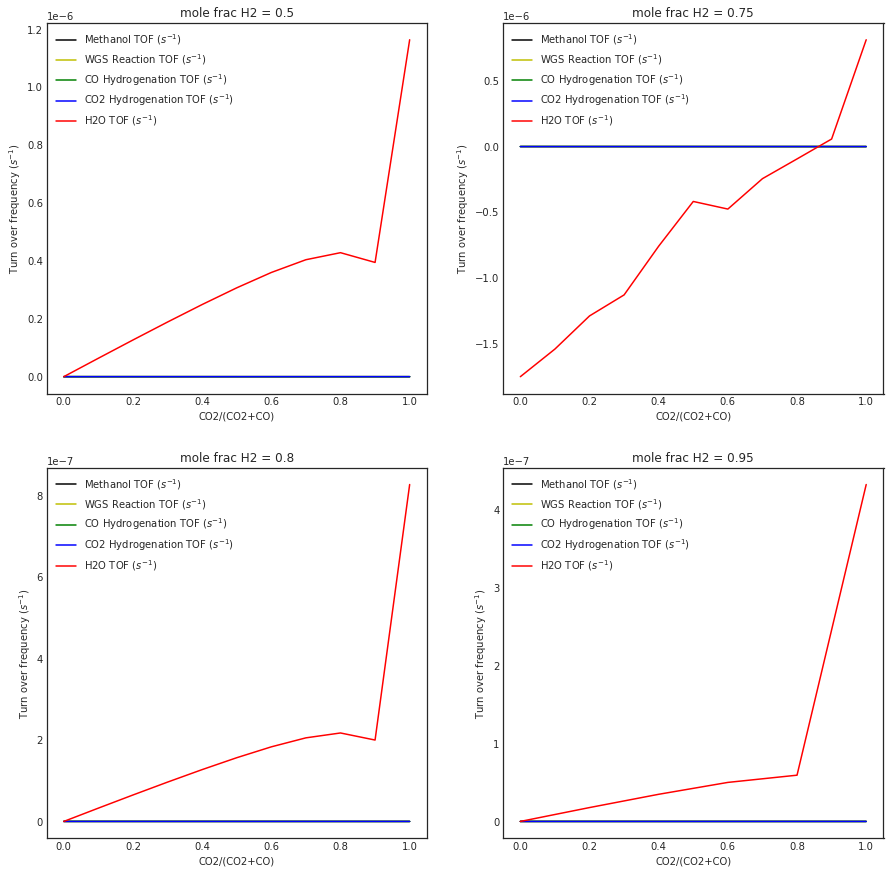

In [55]:
fig_rmg_rates = plot_rates_rmg(data_grab[data_grab["T (K)"] == 528])

## Coverage comparison

Look at the surface coverage and gas phase concentrations for key species

## Plot coverage functions

In [58]:
def plot_covs_grabow(df):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the rmg rates and coverages. 
    df - dataframe to load
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    grabow_labels = [
        "vacant",
        "HCOO",
        "CH3O",
        "H",
        "OH",
    ]
    
    h2_label = "y(H2)"
    co_co2_label = "CO2/(CO+CO2)"
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    
    axes = [(0,0), (0,1), (1,0), (1,1)]
    
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r"}

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(grabow_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df["y(H2)"], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax=ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            ax[slot].set_ylabel("site fraction")
            
    return fig

def plot_covs_rmg(df, labels, gas=False):
    '''
    This function returns a 2x2 set of charts like the ones above, 
    for comparison with the grabow rates and coverages. 
    df - dataframe to load
    labels - list of labels to use. first is the "x" values, then the y
    '''
    
    h2_mol = [0.5, 0.75, 0.8, 0.95]
    
    rmg_labels = labels
        
    h2_label = "x_H2 initial"
    co_co2_label = "CO2/(CO2+CO)"
    color_dict = { 0:"k", 1:"y", 2:"g", 3:"b", 4:"r", 5:"deeppink"}
    fig, ax = plt.subplots(2,2,figsize=(15,15))
    axes = [(0,0), (0,1), (1,0), (1,1)]

    for coord,h2 in enumerate(h2_mol):
        
        for color,label in enumerate(rmg_labels):
            # "slot" where we place chart
            slot = axes[coord]
            df[np.isclose(df[h2_label], h2)].plot(x=co_co2_label,
                                                 y=label,
                                                 ax =ax[slot], 
                                                 color=color_dict[color],
                                                )
            ax[slot].set_title(f'mole frac H2 = {h2}')
            ax[slot].autoscale(enable=True, axis='y')
            if gas: 
                ax[slot].set_ylabel("mole fraction")
            else: 
                ax[slot].set_ylabel("site fraction")
    return fig

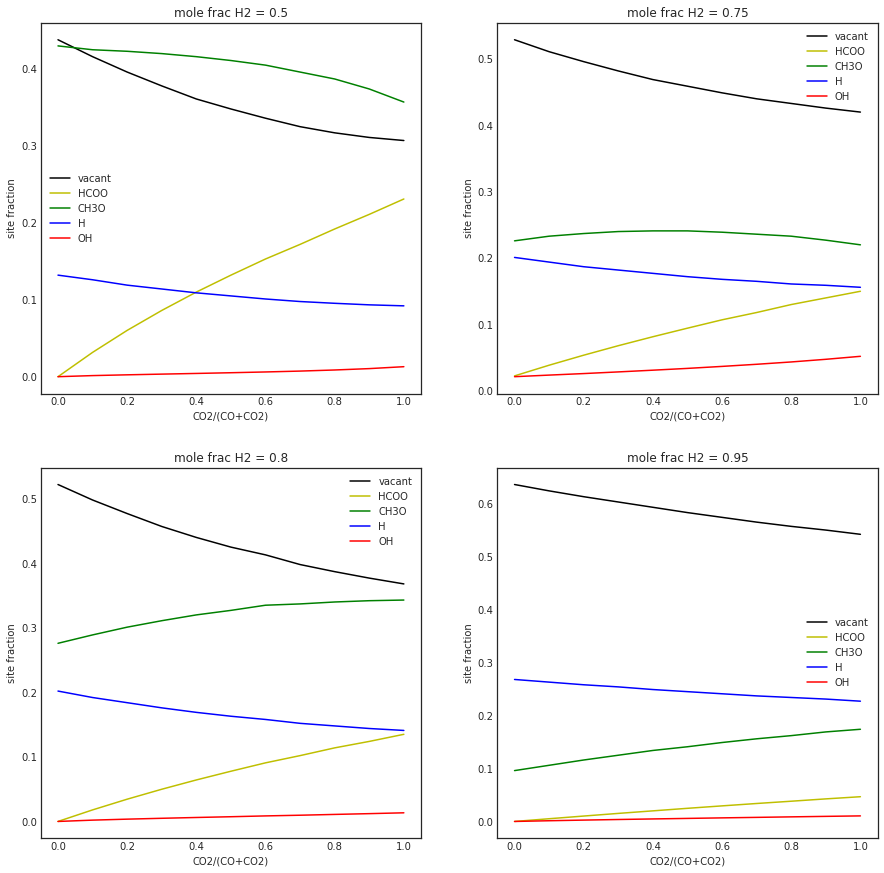

In [59]:
fig_grab_cov = plot_covs_grabow(Grabow_cov)

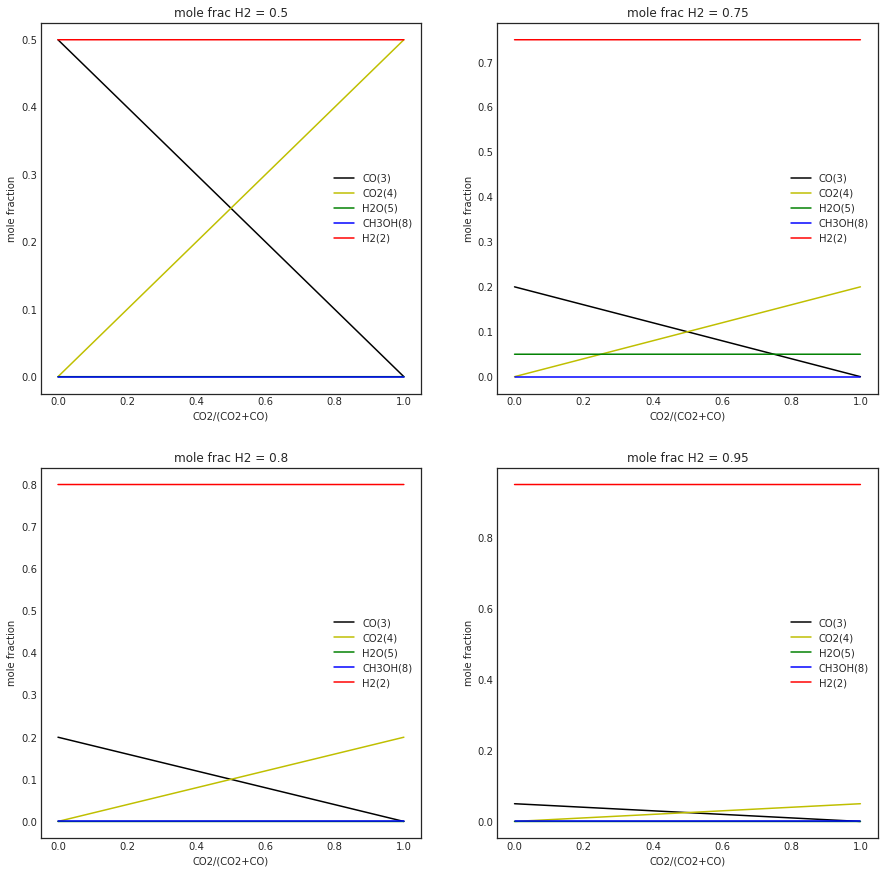

In [60]:
labels = [
    spc_trans["CO"],
    spc_trans["CO2"],
    spc_trans["H2O"],
    spc_trans["CH3OH"],
    spc_trans["H2"],
]

fig_rmg_cov = plot_covs_rmg(data_grab[data_grab["T (K)"] == 528], labels, gas=True)

In [61]:
pp = PdfPages('report.pdf')


pp.savefig(fig_grab_rates)
pp.savefig(fig_rmg_rates)
pp.savefig(fig_grab_cov)
pp.savefig(fig_rmg_cov)
pp.close()

# make parity plots for graaf vs RMG, alongside graaf vs grabow

In [65]:
data_graaf.columns[0:50]

Index(['Unnamed: 0', 'experiment', 'time (s)', 'T (K)', 'P (Pa)', 'V (m^3/s)',
       'x_CO initial', 'x_CO2 initial', 'x_H2 initial', 'x_H2O initial',
       'CO2/(CO2+CO)', '(CO+CO2/H2)', 'T (K) final', 'Rtol', 'Atol',
       'reactor type', 'energy on?', 'catalyst area', 'graaf MeOH TOF 1/s',
       'graaf H2O TOF 1/s', 'RMG MeOH TOF 1/s', 'RMG H2O TOF 1/s',
       'error squared MeOH TOF', 'error squared H2O TOF', 'obj_func',
       'log10(RMG/graaf) MeOH TOF', 'log10(RMG/graaf) H2O TOF',
       'log10(RMG/graaf) TOF', 'N2', 'Ne', 'H2(2)', 'CO(3)', 'CO2(4)',
       'H2O(5)', 'CH2O(6)', 'HCOOH(7)', 'CH3OH(8)', 'HCOOCH3(9)', 'CH4(24)',
       'X(1)', 'H*(10)', 'O*(11)', 'OH*(12)', 'H2O*(13)', 'CO*(14)',
       'CO2*(15)', 'HCO*(16)', 'HCOO*(17)', 'COOH*(18)', 'HCOOH*(19)'],
      dtype='object')

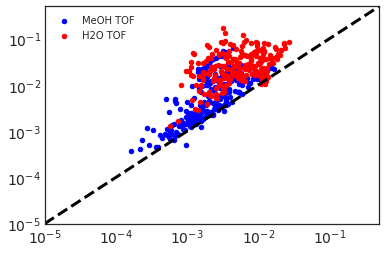

In [79]:
# ax = data_graaf.plot.scatter("graaf MeOH TOF 1/s","RMG MeOH TOF 1/s",loglog=True,color="b")
ax = data_graaf.plot.scatter("graaf H2O TOF 1/s","RMG H2O TOF 1/s",loglog=True,color="b")
data_graaf.plot.scatter("graaf MeOH TOF 1/s","RMG MeOH TOF 1/s",loglog=True,color="r", ax=ax)
ax.set_ylim(1e-4, 5e-1)
ax.set_xlim(1e-4, 5e-1)

ax.set_xlabel("")
ax.set_ylabel("")
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(labels=["MeOH TOF","H2O TOF"])


# make x=y line
plt.gca().set_xlim(left=1e-5)
plt.gca().set_ylim(bottom=1e-5)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)